In [1]:
library(rlang)
library(repr)
library(tidyverse)
options(repr.plot.width=8, repr.plot.height=4)
library(xtable)
library(latex2exp)
library("dplyr")
library(RCTdesign)
library(ggplot2)

Warning message:
“package ‘rlang’ was built under R version 3.4.4”Warning message:
“package ‘repr’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0.9000     ✔ purrr   0.2.5     
✔ tibble  2.0.1          ✔ dplyr   0.7.8     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.1.1          ✔ forcats 0.3.0     
Warning message:
“package ‘tibble’ was built under R version 3.4.4”Warning message:
“package ‘tidyr’ was built under R version 3.4.4”Warning message:
“package ‘purrr’ was built under R version 3.4.4”Warning message:
“package ‘dplyr’ was built under R version 3.4.4”Warning message:
“package ‘stringr’ was built under R version 3.4.4”Warning message:
“package ‘forcats’ was built under R version 3.4.3”── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::as_function() masks rlang::a

Warning message:
“package ‘bindrcpp’ was built under R version 3.4.4”

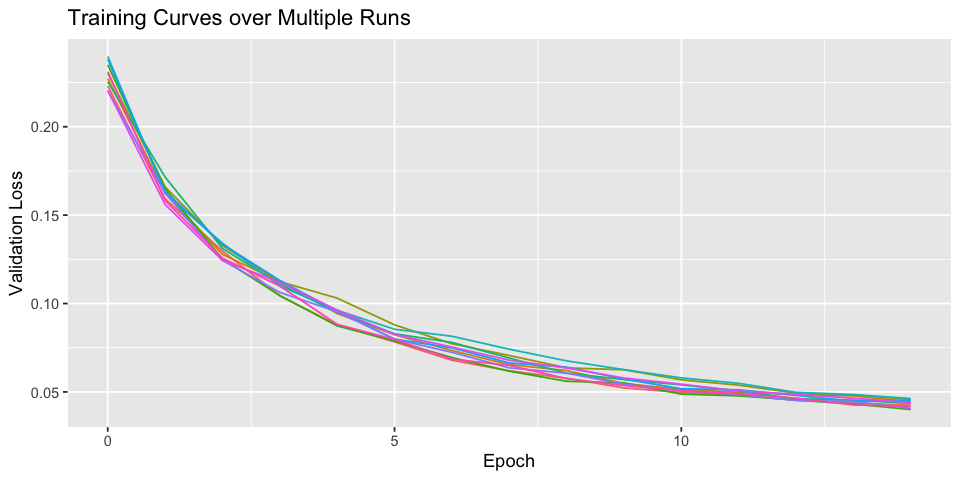

In [2]:
mnist.cnn <- read.csv("./mnistcnn/mnist_complete.csv", header = T)
intermediate <- mnist.cnn[mnist.cnn$Status == "INTERMEDIATE",]
df <- filter(as_tibble(intermediate), dropout %in% sample(unique(intermediate$dropout), 1, replace=F))
df$Trial.ID <- df$Trial.ID - min(df$Trial.ID) + 1
p <- ggplot(subset(df, Trial.ID <= 10), aes(x=Iteration, y=Objective, group=factor(Trial.ID), color=factor(Trial.ID))) + geom_line() +  labs(title = "Training Curves over Multiple Runs", x = "Epoch", y = "Validation Loss", color = "")+ scale_color_discrete(guide=FALSE)
p

In [4]:
# ggsave("figures/curves-same-hp.pdf", plot=p, width=8, height=4)

In [5]:
# devtools::install_github("tidyverse/ggplot2")

In [7]:
# Data operations
group_data <- function(df, grouping_feature, group_size=25, testset=NULL) {
    # Takes Sherpa dataframe and returns dataframe with 
    # Lambda (i.e. group), Group mean and Psi
    #
    # Args:
    #     df: Sherpa output dataframe.
    #     grouping_feature: feature to group by.
    #
    # Returns:
    #     tbl: Lambda (i.e. group), Group mean and Psi
    names(df)[names(df) == grouping_feature] <- 'grouping_feature'
    if (!is.null(testset)) {
        names(df)[names(df) == testset] <- 'PsiTest'
    }
    df <- as_tibble(df)
    grpdf <- df %>% group_by_at('grouping_feature') %>%
            summarise(mean=mean(Objective), count=n()) %>%
            filter(count==group_size) %>%
            arrange(mean) %>%
            mutate(Lambda = 1:n()) %>%
            inner_join(df, by='grouping_feature') %>%
            rename(Psi=Objective, Mean=mean)
    grpdf <- grpdf %>% select(Lambda, starts_with("Psi"))
    
    return(grpdf)
}

subsample_groups <- function(tbl, num_groups) {
    # Helper to subsample by hyperparameter setting (Lambda).
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_groups: the number to subsample i.e. K
    #
    # Returns:
    #     The subsampled tibble.
    return(filter(tbl, Lambda %in% sample(unique(tbl$Lambda), num_groups, replace=F)))
}

subsample_trials <- function(tbl, num_trials, replace=F) {
    # Helper to subsample trials for the existing groups.
    #
    # Args:
    #     tbl: the dataframe/tibble
    #     num_trials: the number to subsample i.e. n_lambda
    #
    # Returns:
    #     The subsampled tibble.
    return(tbl %>% group_by(Lambda) %>% sample_n(num_trials, replace=replace))
}

add_trials <- function(tbl, newtbl) {
    # Helper to combine new trials with previous.
    #
    # Args:
    #     tbl: the dataframe/tibble with the previous trials.
    #     newtbl: the dataframe with the new trials.
    #
    # Returns:
    #     The joined tibble.
    return(full_join(tbl, newtbl, by=c("Lambda", "Psi")) %>%
           arrange(Lambda))
}

select_lambda_star <- function(tbl) {
    # Return the trials that have minimum observed mean.
    #
    # Args:
    #     tbl: the available trials.
    #
    # Returns:
    #     tibble that contains only trials from lambda star.
    return(tbl  %>% 
                group_by(Lambda) %>% 
                summarise(ObservedMean=mean(Psi)) %>% 
                arrange(ObservedMean) %>% 
                mutate(Rank=1:n()) %>% 
                inner_join(tbl, 'Lambda') %>% filter(Rank==1))
}

In [8]:
CalcPocockErrorAndSampleSize <- function (n, alpha, P=0.5){
    # Calculate the alpha dash values and sample size for interim analyses
    #
    # Args:
    #   n: vector of sample size at each analysis.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   A list containing alpha dash and the sample size at each analysis.
    if (length(n) > 1){
        n.delta <- c(n[1], diff(n))
        d <- seqDesign( prob.model="normal",
                       arms=1,
                       alpha=alpha,
                       sample.size=n,
                       P=P,
                       design.scale="E",
                       early.stopping="alternative")
        z.dash <- as.numeric(seqBoundary(d,scale="Z")[,4])
        alpha.dash <- 1.-pnorm(z.dash)
    } else {
        alpha.dash <- alpha
        n.delta <- n
    }
    return(list(alpha.dash=alpha.dash, n.delta=n.delta))
}


filter_by_anova <- function(df, alpha=0.05, verbose=T, wald=F) {
    # Binary Search ANOVA
    #
    # Args:
    #     df: available trials with grouping variable Lambda
    #     alpha: type I error level
    #     verbose: option for turn output on/off
    #
    # Returns:
    #     Tibble of found nullset.
    df <- df  %>% 
        group_by(Lambda) %>% 
        summarise(ObservedMean=mean(Psi)) %>% 
        arrange(ObservedMean) %>% 
        mutate(Rank=1:n()) %>% 
        inner_join(df, 'Lambda')
    K <- max(df$Rank)
    l <- 1
    h <- K
    p <- h
    count <- 1
    while(l != h){
        lmfit <- lm(Psi ~ factor(Lambda), df, subset=Rank<=p)
        pval <- anova(lmfit)$'Pr(>F)'[1]
        reject <- pval < alpha
        if (verbose) {
            cat(paste("Test ", count, "/", ceiling(log2(K)+1), "\n",
                      "l=",l," h=",h," p=",p,"\n",
                      ifelse(reject,"Reject", "Accept"), " (p-val=", pval, ")", "\n\n"
                      , sep=""))
        }
        if(reject){
            h <- p - 1
        } else {
            l <- p
        }
        p <- ceiling((l+h)/2)
        count <- count + 1
    }
    if (verbose) {cat(paste("l=",l," h=",h,"\n", sep=""))}
    return(filter(df, Rank<=l) %>% select(Lambda, Psi))
}


FilterTrials <- function(tbl, alpha.dash, n.lambda.delta) {
    # Testing procedure to generate nullset from candidates.
    #
    # Args:
    #   tbl: data frame containing all available trials
    #   n.lambda: vector of sample sizes for each interim analysis,
    #             also determines the number of analyses.
    #   alpha: overall type 1 error.
    #
    # Returns:
    #   Tibble containing trials in H0.
    num.trials <- 0
    
    # H and H0 denote indices with respect to psi
    for (i in 1:length(n.lambda.delta)){
        new.trials <- subsample_trials(tbl, n.lambda.delta[i], replace=F)
        
        tbl <- anti_join(tbl, new.trials, by = c("Lambda", "Psi"))
        if (i > 1) {
            new.trials <- filter(new.trials, Lambda %in% unique(trials$Lambda))
            trials <- add_trials(trials, new.trials)
        } else {
            trials <- new.trials
        }
        num.trials <- num.trials + nrow(new.trials)
        
        if (n.lambda.delta[i]==1 && length(n.lambda.delta)==1) {
            trials <- filter(trials, Psi==min(trials$Psi))
        } else {
            trials <- filter_by_anova(trials, alpha=alpha.dash[i], verbose=F)
        }
    }
    return(list(H0=trials, num.trials=num.trials))
}

GetLambdaStarPopulation <- function(tbl, H0, sample=F) {
    if (length(unique(H0$Lambda)) > 1) {
        if (sample) {
                lambda.star.sample <- filter(tbl, Lambda==sample(unique(H0$Lambda), 1))
        } else {
            lambda.star.sample <- select_lambda_star(H0)
        }
    } else {
        lambda.star.sample <- H0
    }
    lambda.star.population <- filter(tbl, Lambda %in% unique(lambda.star.sample$Lambda))
    return(lambda.star.population)
}
# TestGetLambdaStarPopulation <- function() {
#     H0 <- FilterTrials(subsample_groups(mnist, 50), c(5), alpha=0.05)$H0
#     print(unique(H0$Lambda)[1] == GetLambdaStarPopulation(mnist,H0,sample=F)$Lambda[1])
#     print(GetLambdaStarPopulation(mnist,H0,sample=T)$Lambda[1] %in% unique(H0$Lambda))
# }
# TestGetLambdaStarPopulation()

plot_groups <- function(df, xlab="Loss") {
    # Helper to make quick plots of the groups.

    # Args:
    #     df: dataframe/tibble containing groups
    #         with at least a Lambda and Psi column.

    # Returns:
    #     Plot.
    p <- ggplot(df, aes(x=Psi, fill=factor(Lambda)))
    p <- p + geom_density(alpha=0.4)
    p <- p + labs(fill = "HP Setting", x=xlab, y="Density")
    return(p)
}

EvalMetrics <- function(tbl, n.lambda, alpha, num.runs, K, testset=F, P=0.5) {
    # Function to evaluate metrics from results section 1.
    #
    # Args:
    #     tbl: all available trials.
    #     n.lambda: vector of sample sizes.
    #     alpha: type I error level
    #     num.runs: number of simulations
    #     K: number of candidate hyperparameter settings
    #     test.tbl: test results.
    #
    # Returns:
    #     List of metrics.
    H0.size <- rep(NA, num.runs)
    lambda.star.in.H0 <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)
    rejection.power <- rep(NA, num.runs)
    epe.sampled <- rep(NA, num.runs)
    epe.best <- rep(NA, num.runs)
    epe.sampled.test <- rep(NA, num.runs)
    epe.best.test <- rep(NA, num.runs)
    
    boundary <- CalcPocockErrorAndSampleSize(n=n.lambda, alpha=alpha, P=P)
    alpha.dash <- boundary$alpha.dash
    n.lambda.delta <- boundary$n.delta
    
    for(i in 1:num.runs) {
        subsampleGroups <- subsample_groups(tbl, num_groups=K)
        rval <- FilterTrials(subsampleGroups, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)
        filteredTbl <- rval$H0
        
        num.trials[i] <- rval$num.trials
        H0.size[i] <- length(unique(filteredTbl$Lambda))
        lambda.star.in.H0[i] <- min(subsampleGroups$Lambda) %in% unique(filteredTbl$Lambda)
        rejection.power[i] <- (K - H0.size[i] - !lambda.star.in.H0[i])/(K-1)
        
        sampled.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=T)
        epe.sampled[i] <- mean(sampled.lambda.star.population$Psi)
        
        
        best.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=F)
        epe.best[i] <- mean(best.lambda.star.population$Psi)
        
        if (testset) {
            epe.sampled.test[i] <- mean(sampled.lambda.star.population$PsiTest)
            epe.best.test[i] <- mean(best.lambda.star.population$PsiTest)
        }

    }
    
    return(list('$\\hat{\\Pr}(k^* \\in [1,\\tilde{k}])$'=mean(lambda.star.in.H0),
                '$\\mathrm{Mean}(\\tilde{k})$'=mean(H0.size),
                '$\\hat{\\Pr}(k \\in [\\tilde{k}+1, K] | k \\neq k^*)$'=mean(rejection.power),
                'Avg Evaluations'=mean(num.trials),
                '$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'=mean(epe.best),
                '$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'=var(epe.best),
                '$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'=mean(epe.sampled),
                '$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'=var(epe.sampled),
                '$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'=mean(epe.best.test),
                '$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'=var(epe.best.test),
                '$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'=mean(epe.sampled.test),
                '$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'=var(epe.sampled.test)
    ))
}


EvalMetricsFullResults <- function(tbl, n.lambda, alpha, num.runs, K, testset=F, P=0.5) {
    # Function to evaluate metrics from results section 1.
    #
    # Args:
    #     tbl: all available trials.
    #     n.lambda: vector of sample sizes.
    #     alpha: type I error level
    #     num.runs: number of simulations
    #     K: number of candidate hyperparameter settings
    #     test.tbl: test results.
    #
    # Returns:
    #     List of metrics.
    H0.size <- rep(NA, num.runs)
    lambda.star.in.H0 <- rep(NA, num.runs)
    num.trials <- rep(NA, num.runs)
    rejection.power <- rep(NA, num.runs)
    epe.sampled <- rep(NA, num.runs)
    epe.best <- rep(NA, num.runs)
    epe.sampled.test <- rep(NA, num.runs)
    epe.best.test <- rep(NA, num.runs)
    
    boundary <- CalcPocockErrorAndSampleSize(n=n.lambda, alpha=alpha, P=P)
    alpha.dash <- boundary$alpha.dash
    n.lambda.delta <- boundary$n.delta
    
    for(i in 1:num.runs) {
        subsampleGroups <- subsample_groups(tbl, num_groups=K)
        rval <- FilterTrials(subsampleGroups, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)
        filteredTbl <- rval$H0
        
        num.trials[i] <- rval$num.trials
        H0.size[i] <- length(unique(filteredTbl$Lambda))
        lambda.star.in.H0[i] <- min(subsampleGroups$Lambda) %in% unique(filteredTbl$Lambda)
        rejection.power[i] <- (K - H0.size[i] - !lambda.star.in.H0[i])/(K-1)
        
        sampled.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=T)
        epe.sampled[i] <- mean(sampled.lambda.star.population$Psi)
        
        
        best.lambda.star.population <- GetLambdaStarPopulation(tbl=tbl, H0=filteredTbl, sample=F)
        epe.best[i] <- mean(best.lambda.star.population$Psi)
        
        if (testset) {
            epe.sampled.test[i] <- mean(sampled.lambda.star.population$PsiTest)
            epe.best.test[i] <- mean(best.lambda.star.population$PsiTest)
        }

    }
    
    return(list('$\\hat{\\Pr}(k^* \\in [1,\\tilde{k}])$'=mean(lambda.star.in.H0),
                '$\\mathrm{Mean}(\\tilde{k})$'=mean(H0.size),
                '$\\hat{\\Pr}(k \\in [\\tilde{k}+1, K] | k \\neq k^*)$'=mean(rejection.power),
                'Avg Evaluations'=mean(num.trials),
                'E(\\Psi(\\lambda^*))'=epe.best,
                'E(\\Psi^T(\\lambda^*))'=epe.best.test,
                'E(\\Psi(\\lambda^s))'=epe.sampled,
                'E(\\Psi^T(\\lambda^s))'=epe.sampled.test
    ))
}

In [5]:
TestFilterByAnova <- function(K){
    n <- 10
    for(k.tilde in (K):1){
        df <- data.frame(Objective=rnorm(k.tilde*n, mean=0, sd=1), Trial=rep(1:k.tilde, each=n))
        if (k.tilde < K){
            df <- rbind(df, data.frame(Objective=rnorm((K-k.tilde)*n, mean=20, sd=1), Trial=rep((k.tilde+1):K, each=n)))
        }         
        df <- group_data(df, grouping_feature='Trial', group_size=n)
        out <- capture.output(filter_by_anova(df, verbose=T))
        num.tests <- sum(grepl('Test', out))
        cat(paste("K=", K, " k.tilde=", k.tilde, " num.tests=", num.tests, " ceil(log2(K))+1=", ceiling(log2(K))+1, "\n",  sep=""))
    }
}
TestFilterByAnova(K=9)

K=9 k.tilde=9 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=8 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=7 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=6 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=5 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=4 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=3 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=2 num.tests=4 ceil(log2(K))+1=5
K=9 k.tilde=1 num.tests=4 ceil(log2(K))+1=5


In [4]:
TableCreator <- function(results=NULL, caption="", label="") {
    cat(paste("\\begin{table}\n",
              "\\caption{", caption, "\\label{tab:", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{l", paste(rep("c", 5), sep="", collapse=""),"}\n",
              "\\hhline{=====}\n", sep=""))
    
    cat(paste(paste(c("$n_\\lambda$", names(results[[1]])), collapse=" & "), "\\\\\n", sep=""))
    cat("\\hline\n")
    for(K in names(results)){
        if(K != "50"){
            cat(paste(rep("&", 5), sep="", collapse=""), "\\\\\n")
        }
        cat(paste("\\underline{$K=", K, "$}", paste(rep("&", 5), sep="", collapse=""), "\\\\\n"))
        for(m in c('$\\hat{\\Pr}(k^* \\in [1,\\tilde{k}])$',
                '$\\mathrm{Mean}(\\tilde{k})$',
                '$\\hat{\\Pr}(k \\in [\\tilde{k}+1, K] | k \\neq k^*)$',
                'Avg Evaluations')){
            row <- NULL
            for(n in names(results[[K]])) {
                row <- c(row, as.character(signif(results[[K]][[n]][[m]], 2)))
            }
            cat(paste(paste(c(m, row), collapse=" & "),"\\\\", "\n"))
        }   
    }
    cat(paste("\n\\hline\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
    
}

# Type I Error

### Binary Search ANOVA

In [130]:
K <- 100
n <- 3
alpha <- 0.05
num.runs <- 100
H0.size <- rep(NA, num.runs)
for(i in 1:num.runs){
    df <- as.tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- filter_by_anova(df=df, alpha=alpha, verbose=F)
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
H0.size[which(H0.size<K)]

[1] 0.03

[1] 98 98 99

### Binary Search ANOVA embedded in Sequential Test

In [62]:
K <- 100
n <- 10
n.lambda <- c(3,6,9)
alpha <- 0.05
num.runs <- 500
H0.size <- rep(NA, num.runs)
boundary <- CalcPocockErrorAndSampleSize(n=n.lambda, alpha=alpha, P=0.5)
alpha.dash <- boundary$alpha.dash
n.lambda.delta <- boundary$n.delta
for(i in 1:num.runs){
    df <- as_tibble(data.frame(Psi=rnorm(K*n, mean=0, sd=1), Lambda=rep(1:K, each=n)))
    filtered.df <- FilterTrials(tbl=df, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)$H0
    H0.size[i] <- length(unique(filtered.df$Lambda))
}
mean(H0.size<K)
H0.size[which(H0.size<K)]

[1] 0.056

[1] 99 97 99 92 99 98 99 99 97 99 98 95 98 98 98 99 98 99 99 99 99 99 99 98 95
[26] 99 97 99

# Motivating Example

In [97]:
f <- function(x, sd=5){
    y <- (x-3)^2 + 10
    if(sd==0){
        return(y)
    }else{
        return(y + rnorm(length(x), mean=0, sd=sd))
    }
}

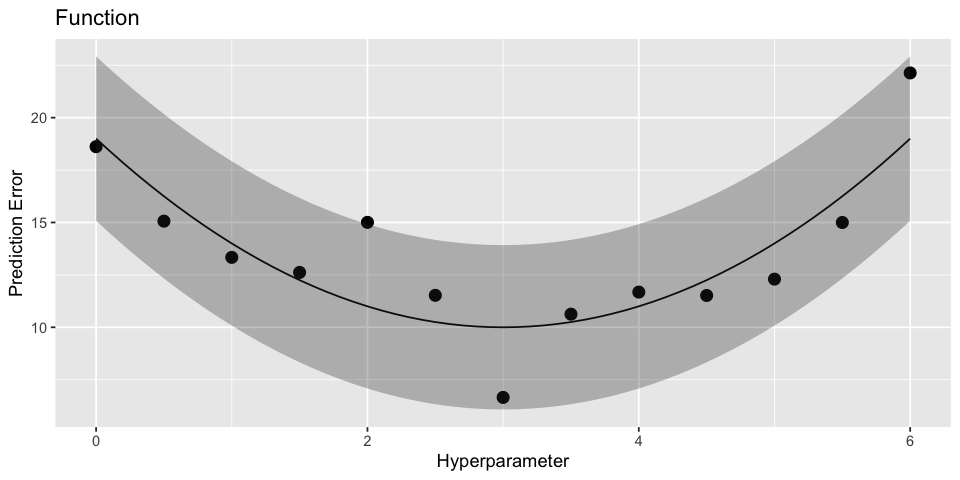

In [98]:
rlim <- 6
x <- seq(0, rlim, 0.1)
xeval <- seq(0, rlim, 0.5)
function.df <- data.frame(x=x, y=f(x, sd=0), lwr=f(x, sd=0)-1.96*2, upr=f(x, sd=0)+1.96*2)
points.df <- data.frame(x=xeval, y=f(xeval, sd=2))
p <- ggplot(points.df, aes(x=x, y=y))+
    labs(x="Hyperparameter", y = "Prediction Error", title="Function")+
    geom_point(aes(), size=3)+
    geom_line(data=function.df)+
    geom_ribbon(data=function.df,aes(ymin=lwr,ymax=upr),alpha=0.3)+
    theme(legend.position="none")
p
# ggsave("figures/parabola-1.pdf", plot=p, width=5, height=4)

In [139]:
x <- seq(0, rlim, 0.5)
# x.0 <- seq(0, rlim, 0.5/3.2)
x.0 <- seq(0, rlim, 0.5)
n <- 10
X <- matrix(rep(x,each=n),nrow=n)
X.0 <- matrix(rep(x.0,each=n),nrow=n)
run.toy.example <- function(X, n.lambda.delta, alpha.dash){
    Y <- f(X, sd=2)
    colnames(Y) <- X[1,]
    toy.raw <- gather(as.data.frame(Y)) %>% rename(Objective=value, x=key)
    toy.raw$x <- as.numeric(toy.raw$x)
    toy.df <- group_data(toy.raw, 'x', group_size=dim(X)[1])
    toy.result <- FilterTrials(toy.df, n.lambda.delta=n.lambda.delta, alpha.dash=alpha.dash)$H0 %>%
    select_lambda_star() %>%
    left_join(toy.raw %>% rename(Psi=Objective), by=c('Psi')) %>% select(c('ObservedMean', 'x')) %>% head(1)
    return(toy.result)
}

In [140]:
num.runs <- 1000
alpha <- 0.05
first <- T

for(P in c(0.5)){
    seqboundary <- CalcPocockErrorAndSampleSize(n=c(3,6,9), alpha=alpha, P=P)
    alpha.dash <- seqboundary$alpha.dash
    n.lambda.delta <- seqboundary$n.delta
    for(i in 1:num.runs){
        rval <- run.toy.example(X,n.lambda.delta=n.lambda.delta,alpha.dash=alpha.dash)
        if(first){
            rval$Method = '3,6,9'
            toy.df <- as.data.frame(rval, stringsAsFactors = T)
            
            first <- F
        }else{
            toy.df <- add_row(toy.df, ObservedMean=rval$ObservedMean, x=rval$x, Method='3,6,9')
        }
        
    }
}

seqboundary <- CalcPocockErrorAndSampleSize(n=c(1), alpha=alpha)
alpha.dash <- seqboundary$alpha.dash
n.lambda.delta <- seqboundary$n.delta
for(i in 1:num.runs){
    rval <- run.toy.example(X.0,n.lambda.delta=n.lambda.delta,alpha.dash=alpha.dash)
    toy.df <- add_row(toy.df, ObservedMean=rval$ObservedMean, x=rval$x, Method='1')
}
toy.df$Expected <- f(toy.df$x, sd=0)

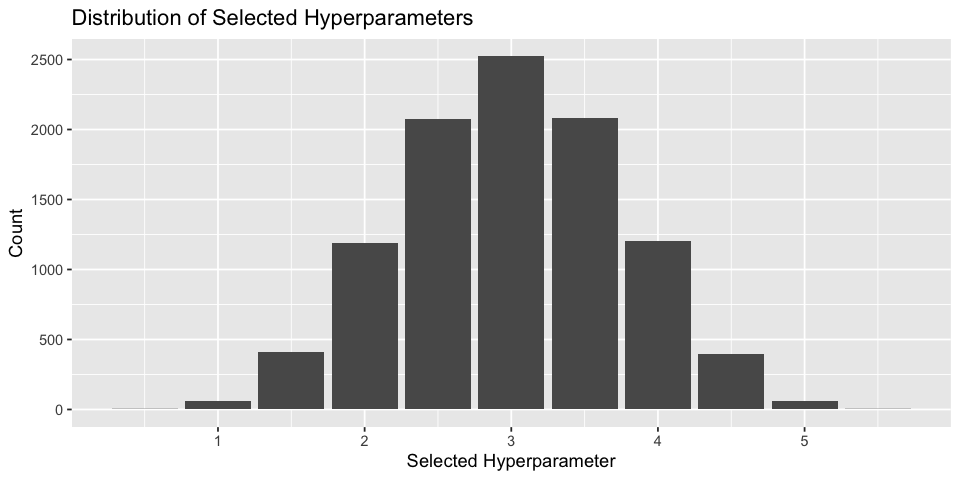

In [262]:
motivating.example.bar <- ggplot(subset(toy.df, Method=='1'), aes(x=x)) +
                          geom_bar(position="dodge") +
                          labs(x="Selected Hyperparameter", y = "Count", title="Distribution of Selected Hyperparameters")
motivating.example.bar
ggsave("figures/parabola-1-barchart.pdf", plot=motivating.example.bar, width=5, height=4)

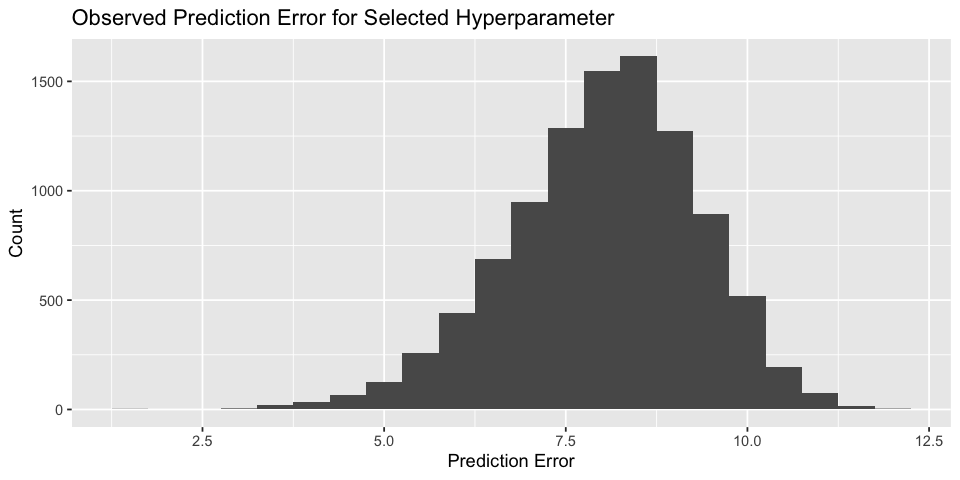

In [263]:
motivating.example.obs <- ggplot(subset(toy.df, Method=='1'), aes(x=ObservedMean)) + 
labs(x="Prediction Error", y = "Count", title="Observed Prediction Error for Selected Hyperparameter")+
  geom_histogram(binwidth=0.5)
motivating.example.obs
ggsave("figures/parabola-1-observed.pdf", plot=motivating.example.obs, width=5, height=4)

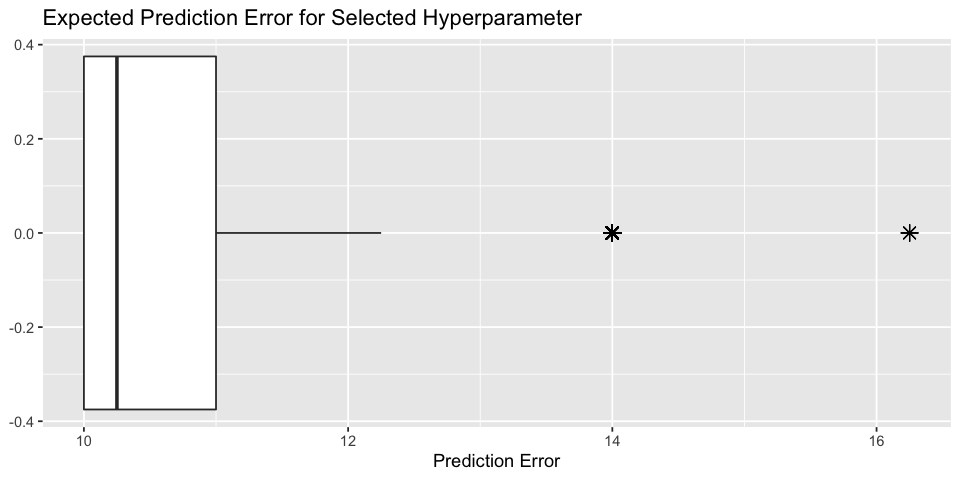

In [264]:
motivating.example.box <- ggplot(subset(toy.df, Method=='1'), aes(y=Expected)) + 
  geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
  labs(y="Prediction Error", title="Expected Prediction Error for Selected Hyperparameter") +
  coord_flip()
motivating.example.box
ggsave("figures/parabola-1-expected.pdf", plot=motivating.example.box, width=5, height=4)

In [134]:
tail(toy.df)

,ObservedMean,x,Method,Expected,x.round
1995,7.522523,2.833333,1,10.02778,3
1996,6.256183,2.666667,1,10.11111,3
1997,7.025251,1.666667,1,11.77778,2
1998,6.188474,2.833333,1,10.02778,3
1999,8.182072,3.333333,1,10.11111,3
2000,5.948467,3.166667,1,10.02778,3


In [141]:
toy.df %>% group_by(Method) %>% summarise(MeanX=mean(x), VarX=var(x), MeanExp=mean(Expected), VarExp=var(Expected), Count=n())

Method,MeanX,VarX,MeanExp,VarExp,Count
1,2.967188,0.4574863,10.45811,0.38693105,1000
"3,6,9",3.010000,0.2181181,10.21800,0.07980581,1000


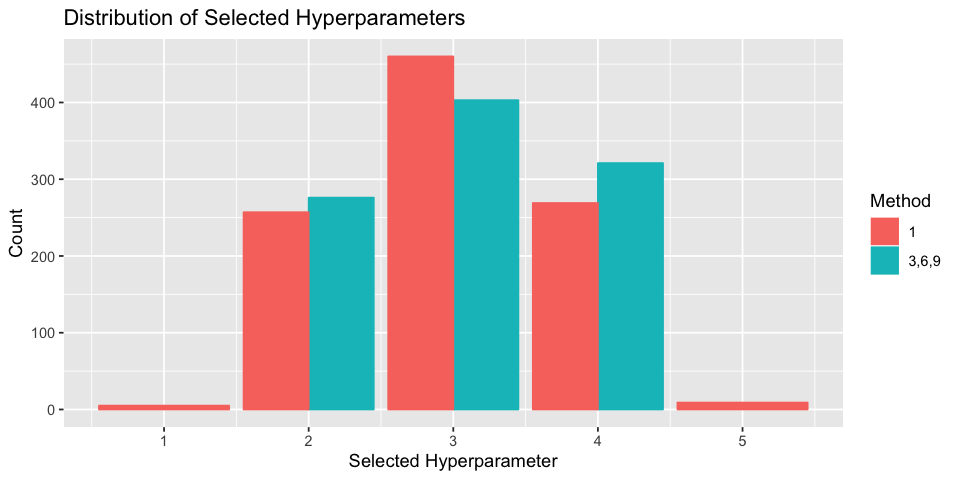

In [131]:
motivating.example.bar <- ggplot(toy.df, aes(x=x, color=Method, fill=Method)) +
                          geom_bar(position="dodge") +
                          labs(x="Selected Hyperparameter", y = "Count", title="Distribution of Selected Hyperparameters")
motivating.example.bar

In [275]:
# ggsave("figures/motivating-example-results-bar.pdf", plot=motivating.example.bar, width=8, height=4)

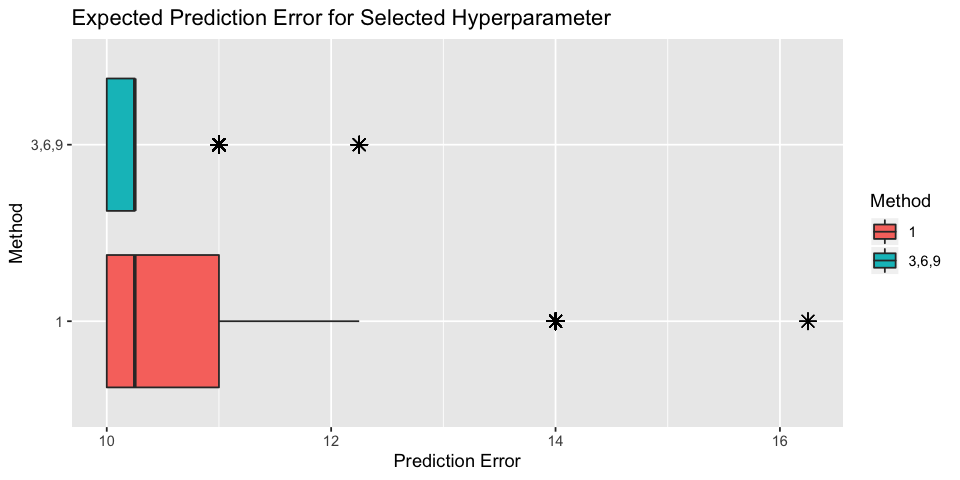

In [272]:
motivating.example.box <- ggplot(toy.df, aes(x=Method, y=f(x, sd=0), fill=Method)) + 
  geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
  labs(y="Prediction Error", title="Expected Prediction Error for Selected Hyperparameter") +
  coord_flip()
motivating.example.box

In [273]:
# ggsave("figures/motivating-example-results-box.pdf", plot=motivating.example.box, width=8, height=4)

# Definitions

In [76]:
K.values <- c(50, 100, 150)
n.lambda <- list('1'=c(1), '5'=c(5), '10'=c(10), '3,6,9'=c(3,6,9))
num.runs <- 10
seqboundary.results <- list()

# MNIST

In [12]:
results <- read.csv("./mnistcnn/mnist-unshuffled-merged.csv", header = T)
completed <- subset(results, Status == 'COMPLETED')
mnist <- group_data(completed, 'dropout', testset="test_loss")
cat(paste("Number of Settings: ", length(unique(mnist$Lambda))))

Number of Settings:  592

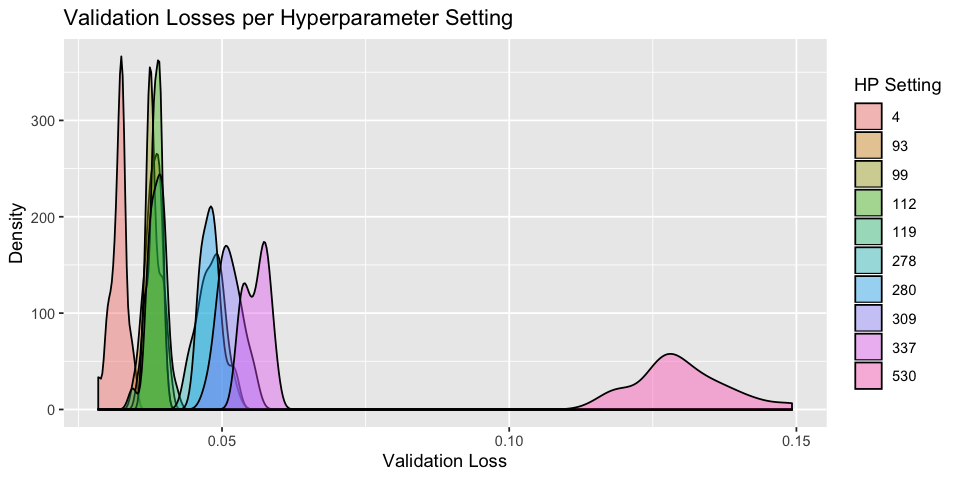

In [68]:
mnist.plot <- ggplot(subsample_trials(subsample_groups(mnist, 10), 25), aes(x=Psi, fill=factor(Lambda))) +
               geom_density(alpha=0.4) +
               labs(fill = "HP Setting", x="Validation Loss", y="Density", title="Validation Losses per Hyperparameter Setting")
mnist.plot

In [69]:
# ggsave("figures/MNIST-density.pdf", plot=mnist.plot, width=8, height=4)

In [77]:
mnist.results <- list()
for(k in K.values) {
    mnist.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
#         cat(paste("Running K=", k, " n.lambda=", paste(as.character(n.lambda[[names(n.lambda)[i]]]), sep="", collapse=""), "\n"))
        mnist.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetricsFullResults(tbl=mnist,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                P=0.5,
                                                                K=k,
                                                                testset=T)
    }
}

In [78]:
mnist.caption <- "Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(mnist.results[c('50','100','150')], caption=mnist.caption, label="mnist-results")

\begin{table}
\caption{Results for the MNIST Convolutional Neural Network hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:mnist-results}}
\begin{center}
\begin{tabular}{lccccc}
\hhline{=====}
$n_\lambda$ & 1 & 5 & 10 & 3,6,9\\
\hline
\underline{$K= 50 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.6 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 3.7 & 2.1 & 2.4 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 0.99 & 0.94 & 0.98 & 0.97 \\ 
Avg Evaluations & 50 & 250 & 500 & 190 \\ 
&&&&& \\
\underline{$K= 100 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.7 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 3.8 & 2.4 & 3.2 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 1 & 0.97 & 0.99 & 0.98 \\ 
Avg Evaluations & 100 & 500 & 1000 & 330 \\ 
&&&&& \\
\underline{$K= 150 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.4 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 6.2 & 3.2 & 4.7 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1,

### Distribution of Outcomes

In [79]:
adjusted.K <- ceiling(mnist.results[['150']][['3,6,9']][['Avg Evaluations']])
if (adjusted.K > length(unique(mnist$Lambda))){
    cat("Not enough trials")
} else {
    mnist.results[[as.character(adjusted.K)]][['1']] <- EvalMetricsFullResults(tbl=mnist,
                                                            n.lambda=c(1),
                                                            alpha=0.05,
                                                            num.runs=num.runs,
                                                            P=0.5,
                                                            K=adjusted.K)
}

# A tibble: 3 x 3
  Method    mean    variance
  <chr>    <dbl>       <dbl>
1 1       0.0321 0.000000584
2 3,6,9   0.0320 0.000000196
3 3,6,9-s 0.0327 0.00000119 


# A tibble: 3 x 3
  Method    mean    variance
  <chr>    <dbl>       <dbl>
1 1       0.0321 0.000000584
2 3,6,9   0.0320 0.000000196
3 3,6,9-s 0.0327 0.00000119 


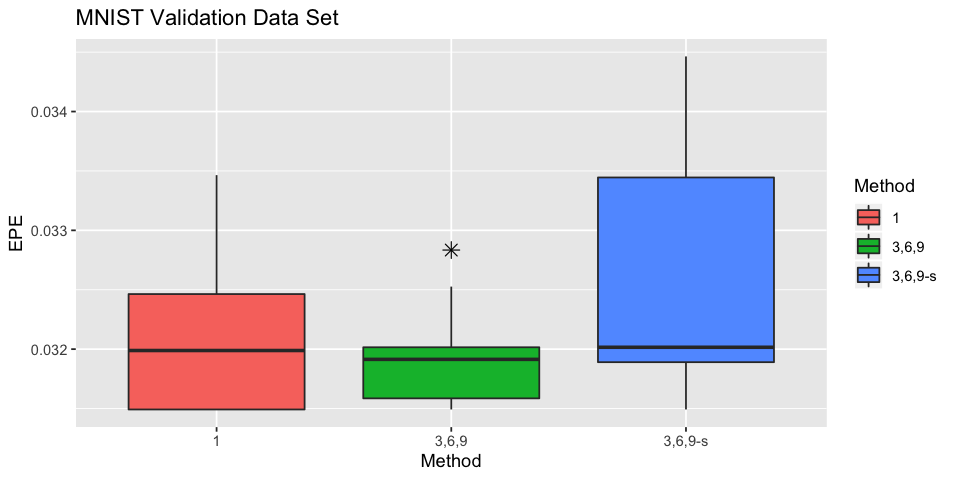

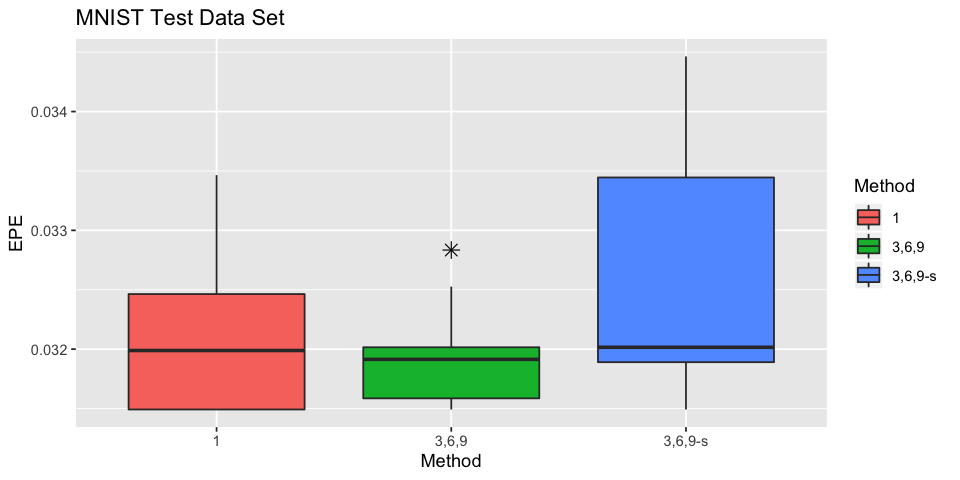

In [80]:
dataset = "MNIST"
rval = rbind(tibble(EPE=mnist.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^*))']], Method='3,6,9'),
             tibble(EPE=mnist.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^s))']], Method='3,6,9-s'),
             tibble(EPE=mnist.results[[as.character(adjusted.K)]][['1']][['E(\\Psi(\\lambda^*))']], Method='1'))
print(rval %>% group_by(Method) %>% summarise(mean=mean(EPE), variance=var(EPE)))
valid.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                          geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                          labs(y="EPE", title=paste(dataset, "Validation Data Set"))
valid.boxplot
# ggsave(paste("figures/", dataset, "-validation.pdf", sep=""), plot=valid.boxplot, width=8, height=4)
rval = rbind(tibble(EPE=mnist.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^*))']], Method='3,6,9'),
             tibble(EPE=mnist.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^s))']], Method='3,6,9-s'),
             tibble(EPE=mnist.results[[as.character(adjusted.K)]][['1']][['E(\\Psi(\\lambda^*))']], Method='1'))
print(rval %>% group_by(Method) %>% summarise(mean=mean(EPE), variance=var(EPE)))
test.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                      geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                      labs(y="EPE", title=paste(dataset, "Test Data Set"))
# ggsave(paste("figures/", dataset, "-test.pdf", sep=""), plot=test.boxplot, width=8, height=4)
test.boxplot

### Sequential Boundary Results

In [81]:
seqboundary.results[["MNIST"]] <- list()

In [82]:
seqboundary.results[["MNIST"]][["0.5"]] <- mnist.results[['150']][['3,6,9']]

seqboundary.results[["MNIST"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'] <- mean(mnist.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^*))"]])
seqboundary.results[["MNIST"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'] <- var(mnist.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^*))"]])
seqboundary.results[["MNIST"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'] <- mean(mnist.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^s))"]])
seqboundary.results[["MNIST"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'] <- var(mnist.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^s))"]])

seqboundary.results[["MNIST"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'] <- mean(mnist.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^*))"]])
seqboundary.results[["MNIST"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'] <- var(mnist.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^*))"]])
seqboundary.results[["MNIST"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'] <- mean(mnist.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^s))"]])
seqboundary.results[["MNIST"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'] <- var(mnist.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^s))"]])

In [83]:
seqboundary.results[["MNIST"]][['0.25']] <- list()
seqboundary.results[["MNIST"]][['0.75']] <- list()
seqboundary.results[["MNIST"]][['1.']] <- list()
for(P in names(seqboundary.results[["MNIST"]])){
    seqboundary.results[["MNIST"]][[P]] <- EvalMetrics(tbl=mnist,
                                                                n.lambda=c(3,6,9),
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=150,
                                                                P=as.numeric(P),
                                                                testset=T) 
}

In [289]:
# results.shuffled <- read.csv("./mnistcnn/mnist_with_test_set_merged.csv", header = T)
# completed.shuffled <- subset(results.shuffled, Status == 'COMPLETED')
# mnist.shuffled <- group_data(completed.shuffled, 'dropout', testset="test_loss")

# IMDB

In [20]:
imdb.csv <- read.csv("./imdblstm/imdb_results.csv", header = T)
imdb.csv$Objective <- 1.-imdb.csv$Objective+rnorm(nrow(imdb.csv), 0, 0.00001)
imdb.csv$test_error <- 1.-imdb.csv$test_acc
imdb <- group_data(imdb.csv, 'dropout_embedding', testset='test_error')

In [21]:
imdb.csv <- read.csv("./imdblstm/imdb_results.csv", header = T)

In [22]:
sum(!is.na(imdb.csv$test_acc))

[1] 15549

In [23]:
length(unique(imdb$Lambda))

[1] 553

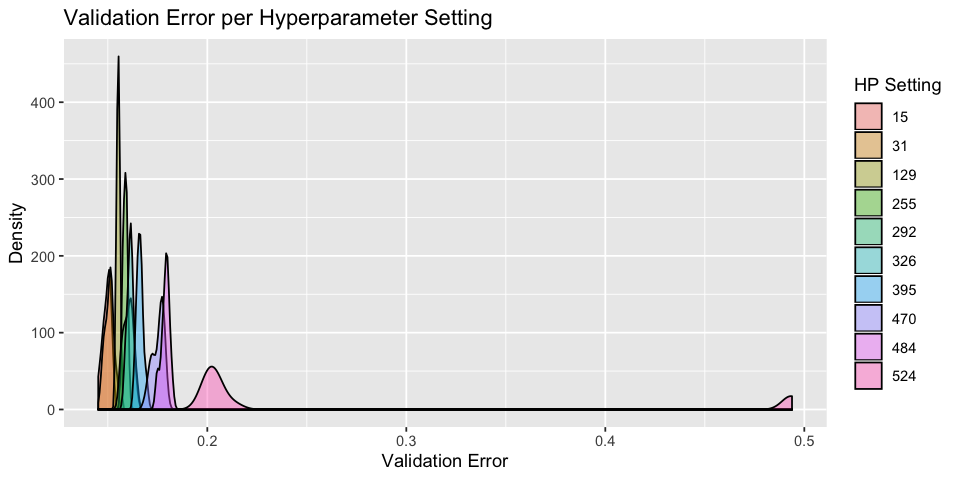

In [119]:
imdb.plot <- ggplot(subsample_trials(subsample_groups(imdb, 10), 25), aes(x=Psi, fill=factor(Lambda))) +
               geom_density(alpha=0.4) +
               labs(fill = "HP Setting", x="Validation Error", y="Density", title="Validation Error per Hyperparameter Setting")
imdb.plot

In [24]:
# ggsave("figures/IMDB-density.pdf", plot=imdb.plot, width=8, height=4)

In [102]:
imdb.results <- list()
for(k in K.values) {
    imdb.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        imdb.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetricsFullResults(tbl=imdb,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k,
                                                                testset=T)
    }
}

In [103]:
imdb.caption <- "Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(imdb.results, caption=imdb.caption, label="imdb-results")

\begin{table}
\caption{Results for the IMDB LSTM hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:imdb-results}}
\begin{center}
\begin{tabular}{lccccc}
\hhline{=====}
$n_\lambda$ & 1 & 5 & 10 & 3,6,9\\
\hline
\underline{$K= 50 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.5 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 5.2 & 3.6 & 3.2 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 0.99 & 0.91 & 0.95 & 0.96 \\ 
Avg Evaluations & 50 & 250 & 500 & 180 \\ 
&&&&& \\
\underline{$K= 100 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.5 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 5.9 & 5.5 & 4.2 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 0.99 & 0.95 & 0.95 & 0.97 \\ 
Avg Evaluations & 100 & 500 & 1000 & 340 \\ 
&&&&& \\
\underline{$K= 150 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.3 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 12 & 6.2 & 7.1 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 1 &

### Distribution of Outcomes

In [104]:
adjusted.K <- ceiling(imdb.results[['150']][['3,6,9']][['Avg Evaluations']])
if (adjusted.K > length(unique(imdb$Lambda))){
    cat("Not enough trials")
} else {
    imdb.results[[as.character(adjusted.K)]][['1']] <- EvalMetricsFullResults(tbl=imdb,
                                                            n.lambda=c(1),
                                                            alpha=0.05,
                                                            num.runs=num.runs,
                                                            P=0.5,
                                                            K=adjusted.K)
}

# A tibble: 3 x 3
  Method   mean    variance
  <chr>   <dbl>       <dbl>
1 1       0.148 0.000000743
2 3,6,9   0.148 0.000000808
3 3,6,9-s 0.149 0.00000258 


# A tibble: 3 x 3
  Method   mean    variance
  <chr>   <dbl>       <dbl>
1 1       0.148 0.000000743
2 3,6,9   0.148 0.000000808
3 3,6,9-s 0.149 0.00000258 


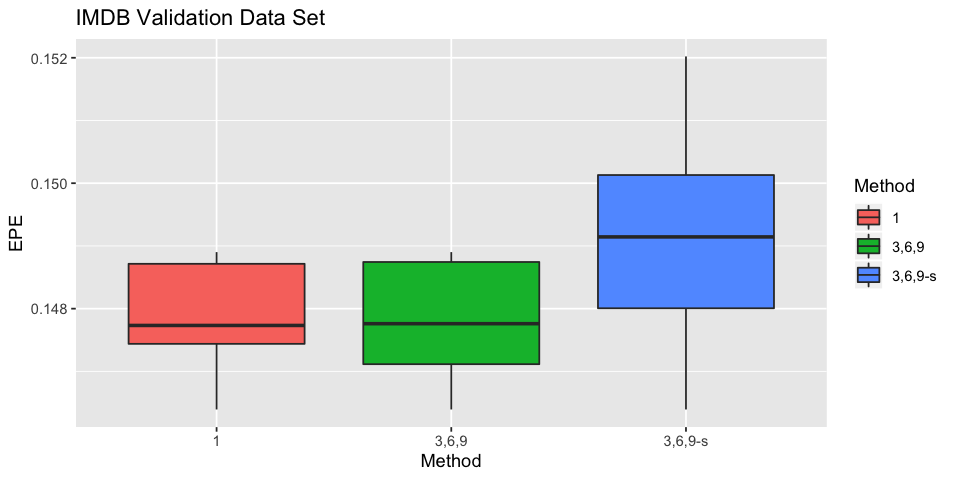

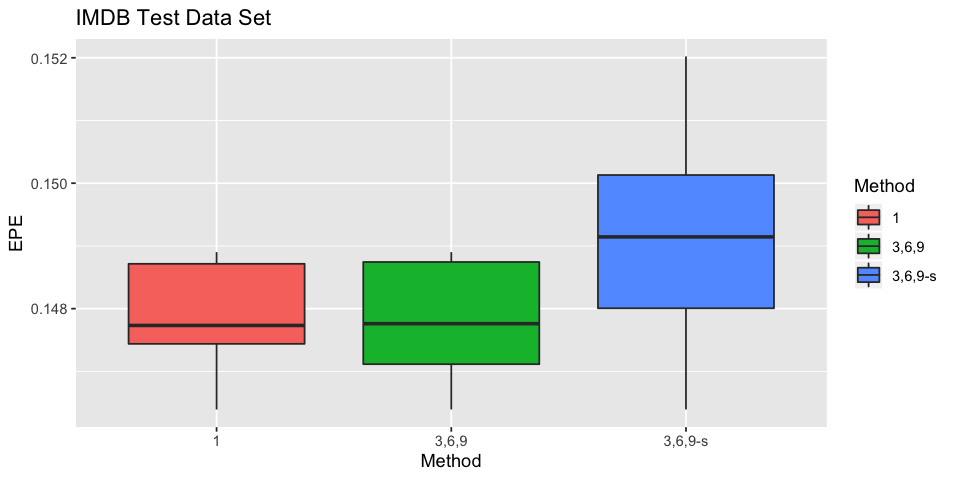

In [105]:
dataset = "IMDB"
rval = rbind(tibble(EPE=imdb.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^*))']], Method='3,6,9'),
             tibble(EPE=imdb.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^s))']], Method='3,6,9-s'),
             tibble(EPE=imdb.results[[as.character(adjusted.K)]][['1']][['E(\\Psi(\\lambda^*))']], Method='1'))
print(rval %>% group_by(Method) %>% summarise(mean=mean(EPE), variance=var(EPE)))
valid.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                          geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                          labs(y="EPE", title=paste(dataset, "Validation Data Set"))
valid.boxplot
# ggsave(paste("figures/", dataset, "-validation.pdf", sep=""), plot=valid.boxplot, width=8, height=4)
rval = rbind(tibble(EPE=imdb.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^*))']], Method='3,6,9'),
             tibble(EPE=imdb.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^s))']], Method='3,6,9-s'),
             tibble(EPE=imdb.results[[as.character(adjusted.K)]][['1']][['E(\\Psi(\\lambda^*))']], Method='1'))
print(rval %>% group_by(Method) %>% summarise(mean=mean(EPE), variance=var(EPE)))
test.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                      geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                      labs(y="EPE", title=paste(dataset, "Test Data Set"))
# ggsave(paste("figures/", dataset, "-test.pdf", sep=""), plot=test.boxplot, width=8, height=4)
test.boxplot

### Sequential Boundary Results

In [106]:
seqboundary.results[["IMDB"]] <- list()

In [107]:
seqboundary.results[["IMDB"]][["0.5"]] <- imdb.results[['150']][['3,6,9']]

seqboundary.results[["IMDB"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'] <- mean(imdb.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^*))"]])
seqboundary.results[["IMDB"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'] <- var(imdb.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^*))"]])
seqboundary.results[["IMDB"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'] <- mean(imdb.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^s))"]])
seqboundary.results[["IMDB"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'] <- var(imdb.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^s))"]])

seqboundary.results[["IMDB"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'] <- mean(imdb.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^*))"]])
seqboundary.results[["IMDB"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'] <- var(imdb.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^*))"]])
seqboundary.results[["IMDB"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'] <- mean(imdb.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^s))"]])
seqboundary.results[["IMDB"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'] <- var(imdb.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^s))"]])

In [108]:
seqboundary.results[["IMDB"]][['0.25']] <- list()
seqboundary.results[["IMDB"]][['0.75']] <- list()
seqboundary.results[["IMDB"]][['1.']] <- list()
for(P in names(seqboundary.results[["IMDB"]])){
    seqboundary.results[["IMDB"]][[P]] <- EvalMetrics(tbl=imdb,
                                                                n.lambda=c(3,6,9),
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=150,
                                                                P=as.numeric(P),
                                                                testset=T) 
}

In [109]:
# imdb.csv <- read.csv("./imdblstm/imdb_results_shuffled.csv", header = T)
# imdb.csv$Objective <- 1.-imdb.csv$Objective+rnorm(nrow(imdb.csv), 0, 0.000000001)
# imdb.csv$test_error <- 1.-imdb.csv$test_acc
# imdb.shuffled <- group_data(imdb.csv, 'dropout_embedding', testset='test_error')

# Boston

In [110]:
boston.csv <- read.csv("./bostongbrt/boston-new-split-merged.csv", header = T)
boston.completed <- subset(boston.csv, Status == 'COMPLETED')
boston.completed <- boston.completed[order(boston.completed$Trial.ID),]
boston <- group_data(boston.completed, 'subsample', testset="test_mse")
cat(paste("Number of Settings: ", length(unique(boston$Lambda))))

Number of Settings:  1250

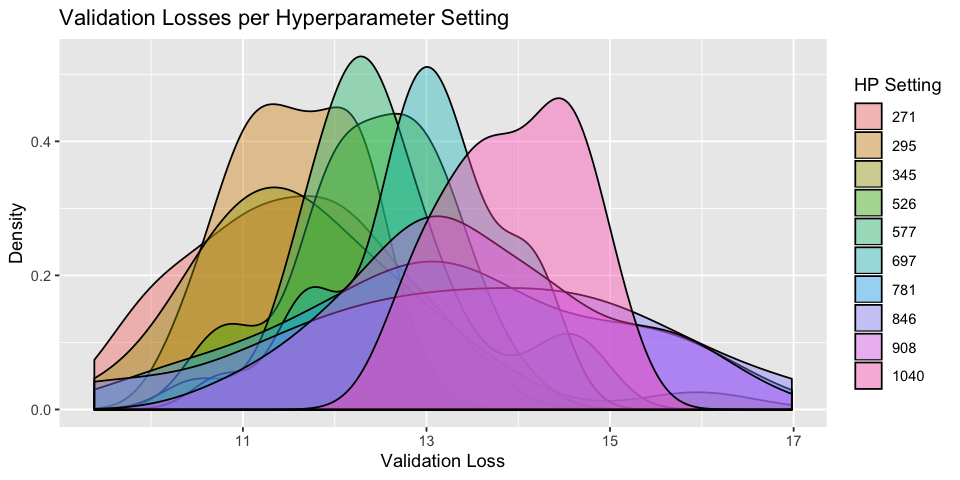

In [111]:
boston.plot <- ggplot(subsample_trials(subsample_groups(boston, 10), 25), aes(x=Psi, fill=factor(Lambda))) +
               geom_density(alpha=0.4) +
               labs(fill = "HP Setting", x="Validation Loss", y="Density", title="Validation Losses per Hyperparameter Setting")
boston.plot

In [112]:
# ggsave("figures/Boston-density.pdf", plot=boston.plot, width=8, height=4)

In [113]:
boston.results <- list()
for(k in K.values) {
    boston.results[[as.character(k)]] <- list()
    for(i in 1:length(n.lambda)) {
        boston.results[[as.character(k)]][[names(n.lambda)[i]]] <- EvalMetricsFullResults(tbl=boston,
                                                                n.lambda=n.lambda[[names(n.lambda)[i]]],
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=k,
                                                                testset=T)
    }
}

In [114]:
boston.caption <- "Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$."
TableCreator(boston.results, caption=boston.caption, label="boston-results")

\begin{table}
\caption{Results for the Boston Housing gradient boosted regression tree hyperparameter optimization across 1000 independent simulations for each value of $K$.\label{tab:boston-results}}
\begin{center}
\begin{tabular}{lccccc}
\hhline{=====}
$n_\lambda$ & 1 & 5 & 10 & 3,6,9\\
\hline
\underline{$K= 50 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.5 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 20 & 13 & 12 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 0.99 & 0.61 & 0.76 & 0.78 \\ 
Avg Evaluations & 50 & 250 & 500 & 280 \\ 
&&&&& \\
\underline{$K= 100 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0.2 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 32 & 26 & 24 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 0.99 & 0.69 & 0.75 & 0.76 \\ 
Avg Evaluations & 100 & 500 & 1000 & 510 \\ 
&&&&& \\
\underline{$K= 150 $} &&&&& \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 0 & 1 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 1 & 47 & 32 & 38 \\ 
$\hat{\Pr}(k \in [\tilde

### Distribution of Outcomes

In [115]:
adjusted.K <- ceiling(boston.results[['150']][['3,6,9']][['Avg Evaluations']])
if (adjusted.K > length(unique(boston$Lambda))){
    cat(paste("Not enough trials. Needed", adjusted.K, "have", length(unique(boston$Lambda))))
} else {
    boston.results[[as.character(adjusted.K)]][['1']] <- EvalMetricsFullResults(tbl=boston,
                                                            n.lambda=c(1),
                                                            alpha=0.05,
                                                            num.runs=num.runs,
                                                            P=0.5,
                                                            testset=T,
                                                            K=adjusted.K)
}

# A tibble: 3 x 3
  Method   mean variance
  <chr>   <dbl>    <dbl>
1 1        10.9   0.104 
2 3,6,9    10.7   0.0484
3 3,6,9-s  10.9   0.0604


# A tibble: 3 x 3
  Method   mean variance
  <chr>   <dbl>    <dbl>
1 1        10.6   0.0886
2 3,6,9    10.5   0.0207
3 3,6,9-s  10.4   0.0322


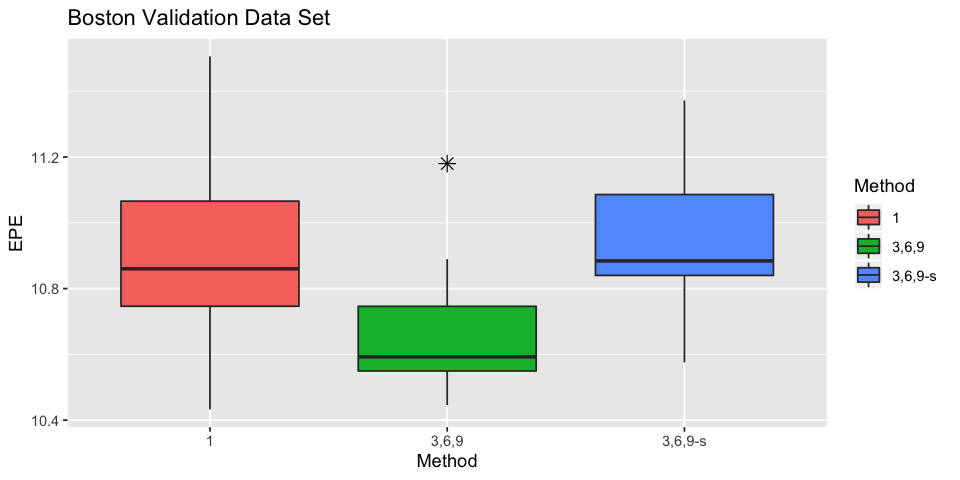

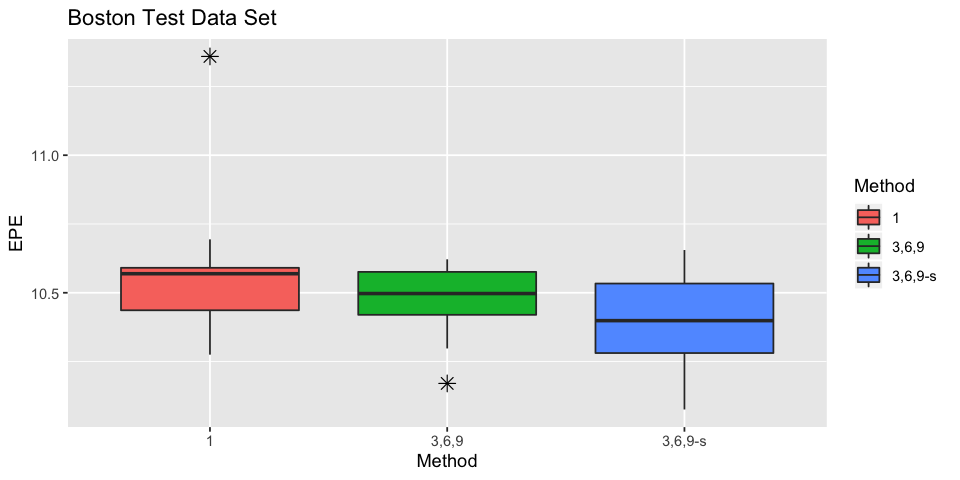

In [116]:
dataset = "Boston"
rval = rbind(tibble(EPE=boston.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^*))']], Method='3,6,9'),
             tibble(EPE=boston.results[['150']][['3,6,9']][['E(\\Psi(\\lambda^s))']], Method='3,6,9-s'),
             tibble(EPE=boston.results[[as.character(adjusted.K)]][['1']][['E(\\Psi(\\lambda^*))']], Method='1'))
valid.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                          geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                          labs(y="EPE", title=paste(dataset, "Validation Data Set"))
print(rval %>% group_by(Method) %>% summarise(mean=mean(EPE), variance=var(EPE)))
valid.boxplot
ggsave(paste("figures/", dataset, "-validation.pdf", sep=""), plot=valid.boxplot, width=8, height=4)
rval = rbind(tibble(EPE=boston.results[['150']][['3,6,9']][['E(\\Psi^T(\\lambda^*))']], Method='3,6,9'),
             tibble(EPE=boston.results[['150']][['3,6,9']][['E(\\Psi^T(\\lambda^s))']], Method='3,6,9-s'),
             tibble(EPE=boston.results[[as.character(adjusted.K)]][['1']][['E(\\Psi^T(\\lambda^*))']], Method='1'))
print(rval %>% group_by(Method) %>% summarise(mean=mean(EPE), variance=var(EPE)))
test.boxplot <- ggplot(rval, aes(x=Method, y=EPE, fill=Method)) + 
                      geom_boxplot(outlier.colour="black", outlier.shape=8, outlier.size=3) +
                      labs(y="EPE", title=paste(dataset, "Test Data Set"))
ggsave(paste("figures/", dataset, "-test.pdf", sep=""), plot=test.boxplot, width=8, height=4)
test.boxplot

### Sequential Boundary Results

In [117]:
seqboundary.results[["Boston"]] <- list()

In [118]:
seqboundary.results[["Boston"]][["0.5"]] <- boston.results[['150']][['3,6,9']]

seqboundary.results[["Boston"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'] <- mean(boston.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^*))"]])
seqboundary.results[["Boston"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$'] <- var(boston.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^*))"]])
seqboundary.results[["Boston"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'] <- mean(boston.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^s))"]])
seqboundary.results[["Boston"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^s}}\\}$'] <- var(boston.results[['150']][['3,6,9']][["E(\\Psi(\\lambda^s))"]])

seqboundary.results[["Boston"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'] <- mean(boston.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^*))"]])
seqboundary.results[["Boston"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$'] <- var(boston.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^*))"]])
seqboundary.results[["Boston"]][["0.5"]]['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'] <- mean(boston.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^s))"]])
seqboundary.results[["Boston"]][["0.5"]]['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^s}}\\}$'] <- var(boston.results[['150']][['3,6,9']][["E(\\Psi^T(\\lambda^s))"]])

In [119]:
seqboundary.results[["Boston"]][['0.25']] <- list()
seqboundary.results[["Boston"]][['0.75']] <- list()
seqboundary.results[["Boston"]][['1.']] <- list()
for(P in names(seqboundary.results[["Boston"]])){
    seqboundary.results[["Boston"]][[P]] <- EvalMetrics(tbl=boston,
                                                                n.lambda=c(3,6,9),
                                                                alpha=0.05,
                                                                num.runs=num.runs,
                                                                K=150,
                                                                P=as.numeric(P),
                                                                testset=T) 
}

In [120]:
# results.shuffled <- read.csv("./bostongbrt/boston-shuffled-merged.csv", header = T)
# completed.shuffled <- subset(results.shuffled, Status == 'COMPLETED')
# boston.shuffled <- group_data(completed.shuffled, 'subsample', testset="test_mse")

# Different sequential boundaries

In [126]:
TableSeqBoundary <- function(results=NULL, caption="", label="") {
    num.columns <- 4
    cat(paste("\\begin{table}\n",
              "\\footnotesize\n",
              "\\caption{", caption, "\\label{tab:", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{l", paste(rep("c", num.columns), sep="", collapse=""),"}\n",
              "\\hhline{=====}\n", sep=""))
    
    cat(paste(paste(c("$P$", names(results[[1]])), collapse=" & "), "\\\\\n"))
    cat("\\hline\n")
    for(dset.name in names(results)){
        if(dset.name != "MNIST"){cat(paste(" ", " "," ", " ", " \\\\\n", sep="&"))}
        cat(paste(paste("\\underline{", dset.name, "}", sep=""), " "," ", " ", " \\\\\n", sep="&"))
        for(K in c('150')){
            for(m in c('$\\hat{\\Pr}(k^* \\in [1,\\tilde{k}])$',
                    '$\\mathrm{Mean}(\\tilde{k})$',
                    '$\\hat{\\Pr}(k \\in [\\tilde{k}+1, K] | k \\neq k^*)$',
                    'Avg Evaluations')){
                row <- NULL
                for(P in names(results[[dset.name]])) {
                    row <- c(row, as.character(round(results[[dset.name]][[P]][[m]], 3)))
                }
                cat(paste(paste(c(m, row), collapse=" & "),"\\\\", "\n"))
            }

            row <- NULL
            for(P in names(results[[dset.name]])) {
                m <- round(results[[dset.name]][[P]][['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$']], 3)
                v <- results[[dset.name]][[P]][['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$']]
                row <- c(row, paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            }
            cat(paste(paste(c('$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$($\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$)', row), collapse=" & "),"\\\\", "\n"))
            row <- NULL
            for(P in names(results[[dset.name]])) {
                m <- round(results[[dset.name]][[P]][['$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$']], 3)
                v <- results[[dset.name]][[P]][['$\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$']]
                row <- c(row, paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            }
            cat(paste(paste(c('$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$($\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$)', row), collapse=" & "),"\\\\", "\n"))
        }
    }
    cat(paste("\n\\hline\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
    
}

In [127]:
TableSeqBoundary(results=seqboundary.results,
                 caption="Results for 1000 simulations using different sequential testing boundaries parameterized by $P$ for $K=150$ candidate settings.",
                 label="sequential-testing-boundaries")

\begin{table}
\footnotesize
\caption{Results for 1000 simulations using different sequential testing boundaries parameterized by $P$ for $K=150$ candidate settings.\label{tab:sequential-testing-boundaries}}
\begin{center}
\begin{tabular}{lcccc}
\hhline{=====}
$P$ & 0.5 & 0.25 & 0.75 & 1. \\
\hline
\underline{MNIST}& & & & \\
$\hat{\Pr}(k^* \in [1,\tilde{k}])$ & 1 & 0.9 & 1 & 1 \\ 
$\mathrm{Mean}(\tilde{k})$ & 4.3 & 4.3 & 4.1 & 4.7 \\ 
$\hat{\Pr}(k \in [\tilde{k}+1, K] | k \neq k^*)$ & 0.978 & 0.977 & 0.979 & 0.975 \\ 
Avg Evaluations & 502.8 & 490.8 & 501.9 & 516.6 \\ 
$\mathbb{\hat{E}}_{\mathrm{HPO}}\{\tau_{\hat{\lambda^*}}\}$($\mathrm{\hat{Var}}_{\mathrm{HPO}}\{\tau_{\hat{\lambda^*}}\}$) & 0.033(6.078e-07) & 0.032(1.544e-07) & 0.032(2.500e-07) & 0.032(6.886e-07) \\ 
$\mathbb{\hat{E}}_{\mathrm{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$($\mathrm{\hat{Var}}_{\mathrm{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$) & 0.027(5.010e-07) & 0.026(3.825e-07) & 0.027(2.928e-07) & 0.027(5.104e-07) \\ 
 & & & & \\
\u

# Appendix: Mean and Variance across repeated runs as compared to standard method

In [31]:
meanvar.num.runs <- 50
meanvar.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist, 'IMDB'=imdb)
meanvar.K <- list('Boston'=c(50, 100, 150), 'MNIST'=c(50, 100, 150), 'Cartpole'=c(55), 'IMDB'=c(50, 100, 150))
adjusted.K <- list()

In [32]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){
    meanvar.results[[dataset.name]] <- list()
    meanvar.results[[dataset.name]][['3,6,9']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9']][[as.character(k)]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }

    adjusted.K[[dataset.name]] <- list()
    for (k in names(meanvar.results[[dataset.name]][['3,6,9']])) {
        adjusted.K[[dataset.name]][[k]] <- ceiling(meanvar.results[[dataset.name]][['3,6,9']][[k]][['Avg Evaluations']])
        cat(ifelse(adjusted.K[[dataset.name]][[k]] > length(unique(datasets[[dataset.name]]$Lambda)), "not enough trials", ""))
    }

    meanvar.results[[dataset.name]][['1']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['1']][[as.character(adjusted.K[[dataset.name]][[as.character(k)]])]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                                    n.lambda=c(1),
                                                                                    alpha=0.05,
                                                                                    num.runs=meanvar.num.runs,
                                                                                    K=adjusted.K[[dataset.name]][[as.character(k)]],
                                                                                    testset=T)
    }
}


not enough trials

ERROR: Error in filter_impl(.data, quo): Evaluation error: cannot take a sample larger than the population when 'replace = FALSE'.


In [128]:
TableMeanVar <- function(results=NULL, adj.k) {
    caption <- ""
    label <- "tab:meanvar-results"
    cat(paste("\\begin{table}\n",
              "\\footnotesize\n",
              "\\caption{", caption, "\\label{", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{lccc}\n",
              "\\toprule\n",
              "\\multicolumn{1}{c}{} & \\multicolumn{1}{c}{$n_\\lambda = 1$}   & \\multicolumn{2}{c}{$n_\\lambda = (3,6,9)$}\\\\\n",
              "& & $\\lambda$ sampled & $\\lambda$ best \\\\\n",
              sep=""))
    
    for(dset in names(results)) {
        cat("\\midrule\n")
        cat(paste(dset, " ", " "," \\\\\n", sep="&"))
        for(k in names(results[[dset]][['3,6,9']])) {
            cat(" &")
            cat(paste("\\multicolumn{1}{c}{$K=", adj.k[[dset]][[as.character(k)]],"$}&"), sep="")
            cat(paste("\\multicolumn{2}{c}{$K=", k,"$}\\\\\n", sep=""))
            cat("Valid &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m*1, 1)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi(\\lambda^*))]$']]
            v <- round(v*(1), 1)
            cat(paste(m, "(", v,")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^s))]$']]
            m <- round(m*1, 1)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^s))]$']]
            v <- round(v*(1), 1)
            cat(paste(m, "(", v,")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m*1, 1)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^*))]$']]
            v <- round(v*(1), 1)
            cat(paste(m, "(", v,")", sep=""))
            
            cat("\\\\\n")
            cat("Test &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^s))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^s))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            cat("\\\\\n")
            
        }
    }
    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
}

In [349]:
TableMeanVar(meanvar.results, adj.k=adjusted.K)

\begin{table}
\footnotesize
\caption{\label{tab:meanvar-results}}
\begin{center}
\begin{tabular}{lccc}
\toprule
\multicolumn{1}{c}{} & \multicolumn{1}{c}{$n_\lambda = 1$}   & \multicolumn{2}{c}{$n_\lambda = (3,6,9)$}\\
& & $\lambda$ sampled & $\lambda$ best \\
\midrule
MNIST& & & \\
 &\multicolumn{1}{c}{$K= 172 $}&\multicolumn{2}{c}{$K=50$}\\
Valid &0(0)&0(0)&0(0)\\
Test &0.027(3.671e-07)&0.0276(1.151e-06)&0.0271(7.161e-07)\\
 &\multicolumn{1}{c}{$K= 342 $}&\multicolumn{2}{c}{$K=100$}\\
Valid &0(0)&0(0)&0(0)\\
Test &0.0267(3.387e-07)&0.0272(3.009e-07)&0.0266(3.066e-07)\\
 &\multicolumn{1}{c}{$K= 494 $}&\multicolumn{2}{c}{$K=150$}\\
Valid &0(0)&0(0)&0(0)\\
Test &0.0265(7.146e-07)&0.0271(5.920e-07)&0.0267(3.990e-07)\\
\midrule
IMDB& & & \\
 &\multicolumn{1}{c}{$K= 183 $}&\multicolumn{2}{c}{$K=50$}\\
Valid &0.1(0)&0.1(0)&0.1(0)\\
Test &NA(  NA)&NA(  NA)&NA(  NA)\\
 &\multicolumn{1}{c}{$K= 376 $}&\multicolumn{2}{c}{$K=100$}\\
Valid &0.1(0)&0.2(0)&0.1(0)\\
Test &NA(  NA)&NA(  NA)&NA(  NA)\\

# Cross Validation Results

In [315]:
meanvar.num.runs <- 100
datasets.shuffled <- list('MNIST'=mnist.shuffled, 'Boston'=boston.shuffled, 'IMDB'=imdb.shuffled)

In [318]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){    
    meanvar.results[[dataset.name]][['3,6,9-shuffled']] <- list()
    for(k in meanvar.K[[dataset.name]]) {
        meanvar.results[[dataset.name]][['3,6,9-shuffled']][[as.character(k)]] <- EvalMetrics(tbl=datasets.shuffled[[dataset.name]],
                                                                    n.lambda=c(3,6,9),
                                                                    alpha=0.05,
                                                                    num.runs=meanvar.num.runs,
                                                                    K=k,
                                                                    P=0.5,
                                                                    testset=T)
    }
}


In [129]:
TableMeanVarCV <- function(results=NULL, adj.k) {
    caption <- ""
    label <- "tab:meanvar-results"
    cat(paste("\\begin{table}\n",
              "\\footnotesize\n",
              "\\caption{", caption, "\\label{", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{lcccc}\n",
              "\\toprule\n",
              "\\multicolumn{1}{c}{} & \\multicolumn{1}{c}{$n_\\lambda = 1$}   & \\multicolumn{2}{c}{$n_\\lambda = (3,6,9)$} & \\multicolumn{1}{c}{$n_\\lambda = (3,6,9)$-CV}\\\\\n",
              "& & $\\lambda$ sampled & $\\lambda$ best & $\\lambda$ best \\\\\n",
              sep=""))
    
    for(dset in names(results)) {
        cat("\\midrule\n")
        cat(paste(dset, " ", " ", " "," \\\\\n", sep="&"))
        for(k in names(results[[dset]][['3,6,9']])) {
            cat(" &")
            cat(paste("\\multicolumn{1}{c}{$K=", adj.k[[dset]][[as.character(k)]],"$}&"), sep="")
            cat(paste("\\multicolumn{3}{c}{$K=", k,"$}\\\\\n", sep=""))
            cat("Valid &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^s))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^s))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Mean[E(\\Psi(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Var[E(\\Psi(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            
            cat("\\\\\n")
            cat("Test &")
            m <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['1']][[as.character(adj.k[[dset]][[as.character(k)]])]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^s))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^s))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")&", sep=""))
            m <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Mean[E(\\Psi^T(\\lambda^*))]$']]
            m <- round(m, 4)
            v <- results[[dset]][['3,6,9-shuffled']][[as.character(k)]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
            cat(paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            cat("\\\\\n")
            
        }
    }
    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
}


In [319]:
TableMeanVarCV(meanvar.results, adj.k=adjusted.K)

\begin{table}
\footnotesize
\caption{\label{tab:meanvar-results}}
\begin{center}
\begin{tabular}{lcccc}
\toprule
\multicolumn{1}{c}{} & \multicolumn{1}{c}{$n_\lambda = 1$}   & \multicolumn{2}{c}{$n_\lambda = (3,6,9)$} & \multicolumn{1}{c}{$n_\lambda = (3,6,9)$-CV}\\
& & $\lambda$ sampled & $\lambda$ best & $\lambda$ best \\
\midrule
MNIST& & & & \\
 &\multicolumn{1}{c}{$K= 176 $}&\multicolumn{3}{c}{$K=50$}\\
Valid &0.0326(6.721e-07)&0.0333(1.503e-06)&0.0329(1.122e-06)&0.033(1.534e-06)\\
Test &0.0269(5.335e-07)&0.0274(9.411e-07)&0.0271(7.729e-07)&0.0281(1.286e-06)\\
 &\multicolumn{1}{c}{$K= 339 $}&\multicolumn{3}{c}{$K=100$}\\
Valid &0.0324(5.935e-07)&0.033(1.071e-06)&0.0324(5.383e-07)&0.0326(8.896e-07)\\
Test &0.0269(5.979e-07)&0.0272(6.937e-07)&0.0268(4.529e-07)&0.0277(1.196e-06)\\
 &\multicolumn{1}{c}{$K= 495 $}&\multicolumn{3}{c}{$K=150$}\\
Valid &0.0322(4.669e-07)&0.0327(6.817e-07)&0.0321(2.913e-07)&0.0322(1.019e-06)\\
Test &0.0267(5.125e-07)&0.0271(5.381e-07)&0.0267(4.425e-07)&0.0

# Different sequential boundaries

In [30]:
TableSeqBoundary <- function(results=NULL, caption="", label="") {
    num.columns <- 4
    cat(paste("\\begin{table}\n",
              "\\footnotesize\n",
              "\\caption{", caption, "\\label{tab:", label, "}}\n",
              "\\begin{center}\n",
              "\\begin{tabular}{l", paste(rep("c", num.columns), sep="", collapse=""),"}\n",
              "\\hhline{=====}\n", sep=""))
    
    cat(paste(paste(c("$P$", names(results[[1]])), collapse=" & "), "\\\\\n"))

    for(dset.name in names(results)){
        cat(paste(" ", " "," ", " ", " \\\\\n", sep="&"))
        cat(paste(paste("\\underline{", dset.name, "}", sep=""), " "," ", " ", " \\\\\n", sep="&"))
        for(K in c('150')){
            for(m in c('$\\hat{\\Pr}(\\lambda^* \\in \\mathcal{H}_0)$',
                    '$\\bar{|\\mathcal{H}_0|}$',
                    '$\\hat{\\Pr}(\\lambda \\in \\mathcal{H}_0^c | \\lambda \\neq \\lambda^*)$',
                    'Avg Evaluations')){
                row <- NULL
                for(P in names(results[[dset.name]])) {
                    row <- c(row, as.character(round(results[[dset.name]][[P]][[K]][[m]], 3)))
                }
                cat(paste(paste(c(m, row), collapse=" & "),"\\\\", "\n"))
            }

            row <- NULL
            for(P in names(results[[dset.name]])) {
                m <- round(results[[dset.name]][[P]][[K]][['$Mean[E(\\Psi(\\lambda^*))]$']], 3)
                v <- results[[dset.name]][[P]][[K]][['$Var[E(\\Psi(\\lambda^*))]$']]
                row <- c(row, paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            }
            cat(paste(paste(c('$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\}$($\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau_{\\hat{\\lambda^*}}\\}$)', row), collapse=" & "),"\\\\", "\n"))
            row <- NULL
            for(P in names(results[[dset.name]])) {
                m <- round(results[[dset.name]][[P]][[K]][['$Mean[E(\\Psi^T(\\lambda^*))]$']], 3)
                v <- results[[dset.name]][[P]][[K]][['$Var[E(\\Psi^T(\\lambda^*))]$']]
                row <- c(row, paste(m, "(", formatC(v, format = "e", digits = 3),")", sep=""))
            }
            cat(paste(paste(c('$\\mathbb{\\hat{E}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$($\\mathrm{\\hat{Var}}_{\\mathrm{HPO}}\\{\\tau^T_{\\hat{\\lambda^*}}\\}$)', row), collapse=" & "),"\\\\", "\n"))
        }
    }

    cat(paste("\n\\bottomrule\n",
    "\\end{tabular}\n",
    "\\end{center}\n",
    "\\end{table}\n"))
    
}

In [119]:
seqboundary.num.runs <- 1000
seqboundary.results <- list()
datasets <- list('Boston'=boston, 'MNIST'=mnist, 'IMDB'=imdb)
seqboundary.K <- list('Boston'=c(150), 'MNIST'=c(150), 'IMDB'=c(150))

In [120]:
for(dataset.name in c('MNIST', 'IMDB', 'Boston')){
    seqboundary.results[[dataset.name]] <- list()
    seqboundary.results[[dataset.name]][['0.25']] <- list()
    seqboundary.results[[dataset.name]][['0.5']] <- list()
    seqboundary.results[[dataset.name]][['0.75']] <- list()
    seqboundary.results[[dataset.name]][['1.']] <- list()
    for(K in seqboundary.K[[dataset.name]]) {
        for(P in names(seqboundary.results[[dataset.name]])){
            seqboundary.results[[dataset.name]][[P]][[as.character(K)]] <- EvalMetrics(tbl=datasets[[dataset.name]],
                                                                        n.lambda=c(3,6,9),
                                                                        alpha=0.05,
                                                                        num.runs=seqboundary.num.runs,
                                                                        K=K,
                                                                        P=as.numeric(P),
                                                                        testset=T) 
        }

    }
}

In [123]:
TableSeqBoundary(results=seqboundary.results,
                 caption="Results for 1000 simulations using different sequential testing boundaries parameterized by $P$ for $K=150$ candidate settings.",
                 label="sequential-testing-boundaries")

\begin{table}
\footnotesize
\caption{\label{tab:}}
\begin{center}
\begin{tabular}{lcccc}
\toprule
$P$ & 0.25 & 0.5 & 0.75 & 1. \\

\midrule
MNIST& & & & \\

\midrule
$K= 150 $ &&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 0.994 & 0.996 & 0.998 & 0.998 \\ 
$\bar{|\mathcal{H}_0|}$ & 4.614 & 4.08 & 3.988 & 3.962 \\ 
$\hat{\Pr}(\lambda \in \mathcal{H}_0^c | \lambda \neq \lambda^*)$ & 0.976 & 0.979 & 0.98 & 0.98 \\ 
Avg Evaluations & 494.898 & 495.57 & 500.106 & 510.21 \\ 
$\mathbb{E}_{\mathcal{HPO}}\{\tau_{\hat{\lambda^*}}\}$($\mathrm{Var}_{\mathcal{HPO}}\{\tau_{\hat{\lambda^*}}\}$) & 0.032(3.743e-07) & 0.032(3.440e-07) & 0.032(3.621e-07) & 0.032(4.339e-07) \\ 
$\mathbb{E}_{\mathcal{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$($\mathrm{Var}_{\mathcal{HPO}}\{\tau^T_{\hat{\lambda^*}}\}$) & 0.027(4.217e-07) & 0.027(4.432e-07) & 0.027(4.109e-07) & 0.027(4.455e-07) \\ 

\midrule
IMDB& & & & \\

\midrule
$K= 150 $ &&&& \\
$\hat{\Pr}(\lambda^* \in \mathcal{H}_0)$ & 1 & 0.996 & 1 & 0.996 \\ 
$\bar{|\ma

# Type I error with real data

In [109]:
type.I.error <- list()
for(dset.name in c('MNIST', 'IMDB', 'Boston')){
    type.I.error[[dset.name]] <- list()
    for(n in c(3, 5, 10)){
        K <- floor(25/n)
        alpha <- 0.05
        num.runs <- 200
        H0.size <- rep(NA, num.runs)
        for(i in 1:num.runs){
            this.Lambda <- sample(length(unique(datasets[[dset.name]]$Lambda)), 1)
            df <- filter(datasets[[dset.name]], Lambda==this.Lambda)
            df$Lambda <- sample(c(rep(1:K, each=n), rep(K, 25-K*n)), replace=F)
            filtered.df <- filter_by_anova(df=df, alpha=alpha, verbose=F)
            H0.size[i] <- length(unique(filtered.df$Lambda))
        }
        type.I.error[[dset.name]][[as.character(n)]] <- mean(H0.size<K)
    }
}
type.I.error

Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm

$MNIST
$MNIST$`3`
[1] 0.035

$MNIST$`5`
[1] 0.07

$MNIST$`10`
[1] 0.035


$IMDB
$IMDB$`3`
[1] 0.08

$IMDB$`5`
[1] 0.04

$IMDB$`10`
[1] 0.025


$Boston
$Boston$`3`
[1] 0.06

$Boston$`5`
[1] 0.04

$Boston$`10`
[1] 0.035

In [112]:
for(dset.name in c('MNIST', 'IMDB', 'Boston')){
    K <- floor(25/12)
    alpha <- 0.05
    num.runs <- 200
    H0.size <- rep(NA, num.runs)
    for(i in 1:num.runs){
        this.Lambda <- sample(length(unique(datasets[[dset.name]]$Lambda)), 1)
        df <- filter(datasets[[dset.name]], Lambda==this.Lambda)
        df$Lambda <- sample(c(rep(1:K, each=n), rep(K, 25-K*n)), replace=F)
        filtered.df <- FilterTrials(tbl=df, n.lambda=c(3,6,9), alpha=alpha)$H0
        H0.size[i] <- length(unique(filtered.df$Lambda))
    }
    type.I.error[[dset.name]][['3,6,9']] <- mean(H0.size<K)
}
type.I.error

Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm(lm(Psi ~ factor(Lambda), df, subset = Rank <= p)):
“ANOVA F-tests on an essentially perfect fit are unreliable”Warning message in anova.lm

$MNIST
$MNIST$`3`
[1] 0.035

$MNIST$`5`
[1] 0.07

$MNIST$`10`
[1] 0.035

$MNIST$`3,6,9`
[1] 0.025


$IMDB
$IMDB$`3`
[1] 0.08

$IMDB$`5`
[1] 0.04

$IMDB$`10`
[1] 0.025

$IMDB$`3,6,9`
[1] 0.04


$Boston
$Boston$`3`
[1] 0.06

$Boston$`5`
[1] 0.04

$Boston$`10`
[1] 0.035

$Boston$`3,6,9`
[1] 0.035

# Distribution of validation losses

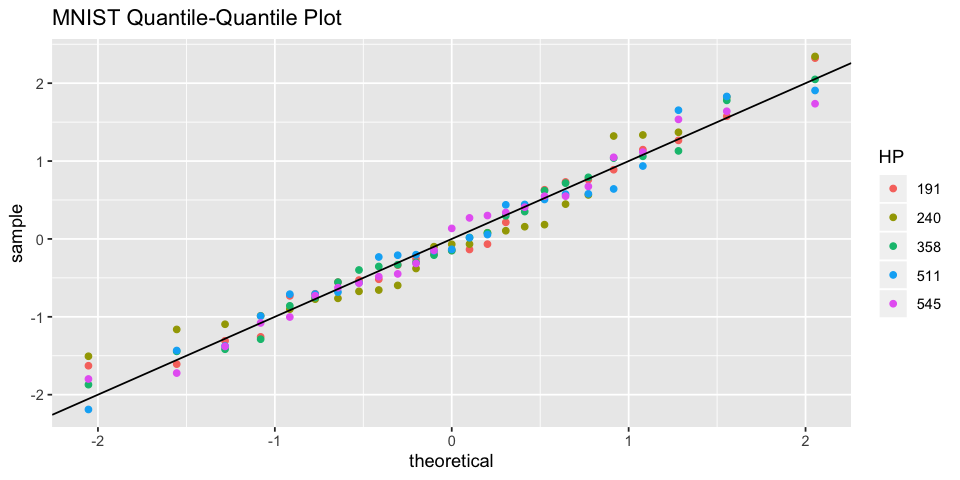

In [73]:
p <- ggplot(subsample_trials(subsample_groups(mnist, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="MNIST Quantile-Quantile Plot")
p
ggsave("figures/MNIST-qqplot.png", plot=p, width=8, height=4)

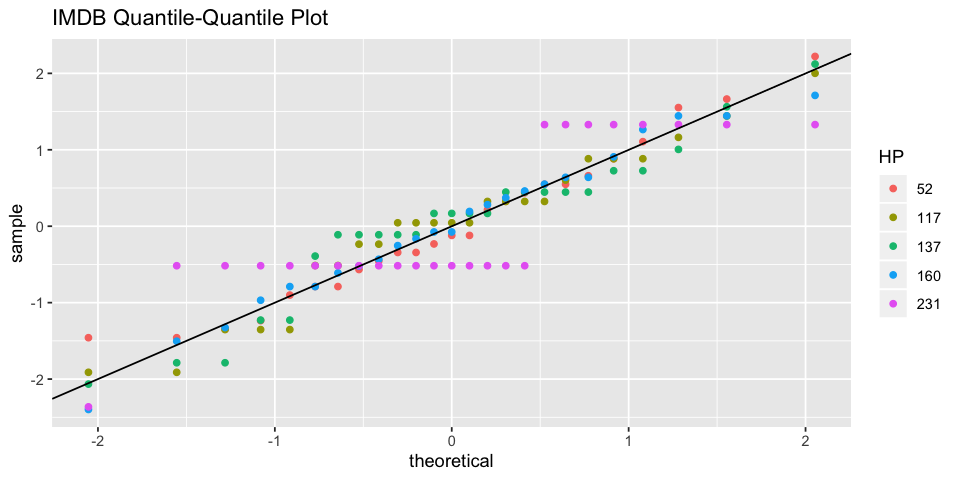

In [74]:
p <- ggplot(subsample_trials(subsample_groups(imdb, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="IMDB Quantile-Quantile Plot")
p
ggsave("figures/IMDB-qqplot.png", plot=p, width=8, height=4)

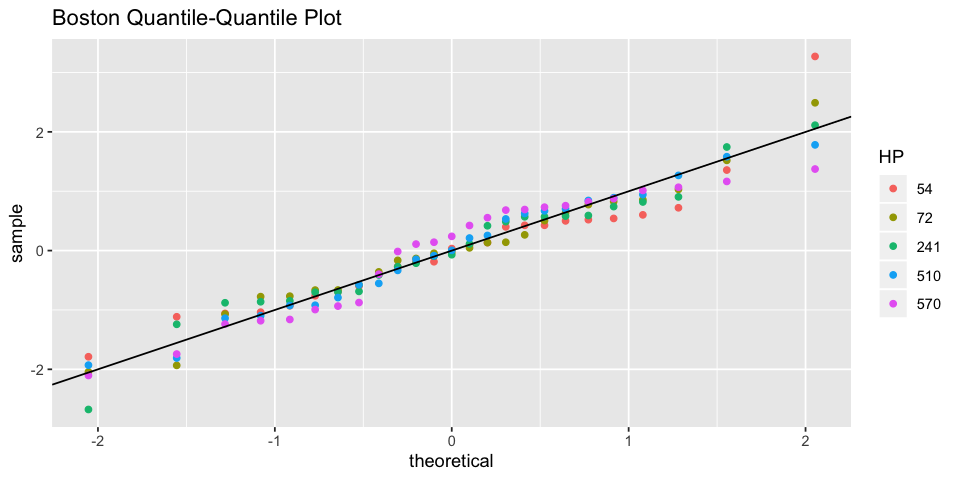

In [75]:
p <- ggplot(subsample_trials(subsample_groups(mnist, 5), 25) %>% mutate(Resids=scale(Psi)),
            aes(sample = Resids, col=factor(Lambda))) + stat_qq() + geom_abline() + labs(col='HP', title="Boston Quantile-Quantile Plot")
p
ggsave("figures/Boston-qqplot.png", plot=p, width=8, height=4)